# Post-processing only (IOU = 0.2) for SUNS

This notebook runs only the post-processing parameter optimization, forcing the IOU threshold to 0.2 and saving results under `demo/mouse7_new/output_IOU_02`.

- Inputs (`network_input`) and `Weights` come from the currently active dataset in `suns/config.py`.
- Outputs are redirected to `demo/mouse7_new/output_IOU_02`.

Adjust the parameters in the next cell if needed.


In [1]:
# Setup and imports
import os, sys, math
import numpy as np
import h5py

# Ensure project root is on path
%cd /gpfs/home/bizzin01/nicole/code/SUNS_nicole
sys.path.insert(1, 'suns')
sys.path.insert(1, '.')
sys.path.insert(1, 'demo')
sys.path.insert(1, 'demo/train_3_test_1')

os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Set to '-1' for CPU only

from suns import config
from suns.PreProcessing.preprocessing_functions import find_dataset
from suns.train_CNN_params import parameter_optimization_cross_validation

import tensorflow as tf
print('TF version:', tf.__version__)
try:
    tf_version_major = int(tf.__version__.split('.')[0])
except Exception:
    tf_version_major = 2

if tf_version_major == 1:
    config_tf = tf.ConfigProto()
    config_tf.gpu_options.allow_growth = True
    sess = tf.Session(config=config_tf)
else:
    gpus = tf.config.list_physical_devices('GPU')
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except Exception as e:
            print('GPU memory growth warning:', e)



/gpfs/data/shohamlab/nicole/code/SUNS_nicole
importing config
TF version: 2.12.1


In [2]:
# Parameters and paths
# Use active dataset to READ inputs/weights
active_set = config.ACTIVE_EXP_SET
list_Exp_ID = config.EXP_ID_SETS[active_set]
dir_video = config.DATAFOLDER_SETS[active_set]
rate_hz = config.RATE_HZ[active_set]
Mag = config.MAG[active_set]

# Write outputs under mouse7_new/output_IOU_02
output_base = os.path.join(config.DATAFOLDER_SETS['mouse7_new'], 'output_IOU_02')
print('Reading from set:', active_set)
print('Writing outputs to:', output_base)

# Directories matching training layout
from_dir_parent = os.path.join(dir_video, config.OUTPUT_FOLDER[active_set])
dir_network_input = os.path.join(from_dir_parent, 'network_input')
weights_path = os.path.join(from_dir_parent, 'Weights')
dir_GTMasks = os.path.join(dir_video, 'GT Masks', 'FinalMasks_')

# Where to save post-proc results
os.makedirs(output_base, exist_ok=True)
dir_output = os.path.join(output_base, 'output_masks')
dir_temp = os.path.join(output_base, 'temp')
os.makedirs(dir_output, exist_ok=True)
os.makedirs(dir_temp, exist_ok=True)

# Hyper-parameter ranges (same as script, IOU fixed to 0.2)
list_minArea = list(range(30, 85, 5))
list_avgArea = [177]
list_thresh_pmap = list(range(130, 235, 10))
thresh_mask = 0.5
thresh_COM0 = 2
list_thresh_COM = list(np.arange(4, 9, 1))
list_thresh_IOU = [0.2]
list_cons = list(range(1, 8, 1))

# Inference options
batch_size_eval = 100
useWT = False
useMP = False
cross_validation = 'leave_one_out'


Reading from set: mouse7_new
Writing outputs to: /gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new/output_IOU_02


In [3]:
# Discover lateral dimensions from raw videos
nvideo = len(list_Exp_ID)
list_Dimens = np.zeros((nvideo, 3), dtype='uint16')
for (eid, Exp_ID) in enumerate(list_Exp_ID):
    h5_video = os.path.join(dir_video, Exp_ID + '.h5')
    with h5py.File(h5_video, 'r') as h5_file:
        dset = find_dataset(h5_file)
        list_Dimens[eid] = h5_file[dset].shape

nframes = np.unique(list_Dimens[:, 0])
Lx = np.unique(list_Dimens[:, 1])
Ly = np.unique(list_Dimens[:, 2])
if len(Lx) * len(Ly) != 1:
    raise ValueError('All training videos must share the same lateral dimensions.')
rows = int(Lx[0])
cols = int(Ly[0])

# Adjust parameter units by magnification
list_minArea = list(np.round(np.array(list_minArea) * Mag ** 2))
list_avgArea = list(np.round(np.array(list_avgArea) * Mag ** 2))
thresh_COM0 = thresh_COM0 * Mag
list_thresh_COM = list(np.array(list_thresh_COM) * Mag)

Params_set = {
    'list_minArea': list_minArea,
    'list_avgArea': list_avgArea,
    'list_thresh_pmap': list_thresh_pmap,
    'thresh_COM0': thresh_COM0,
    'list_thresh_COM': list_thresh_COM,
    'list_thresh_IOU': list_thresh_IOU,
    'thresh_mask': thresh_mask,
    'list_cons': list_cons,
}
print('Params_set prepared. IOU=', list_thresh_IOU)


Params_set prepared. IOU= [0.2]


In [4]:
# Run post-processing parameter optimization only
results = parameter_optimization_cross_validation(
    cross_validation,
    list_Exp_ID,
    Params_set,
    (rows, cols),
    dir_network_input,
    weights_path,
    dir_GTMasks,
    dir_temp,
    dir_output,
    batch_size_eval,
    useWT=useWT,
    useMP=useMP,
    load_exist=False,
)
print('Post-processing optimization finished. Outputs in:')
print('  dir_output:', dir_output)
print('  dir_temp  :', dir_temp)


Video mouse7_773
Load data: 0.6886694431304932 s
16/16 [==============================] - 5s 43ms/step
Average infrence time 3.420278345903259 ms/frame
Using thresh_pmap=130
Used 2.275803565979004 s
Using minArea=5.0, avgArea=28.0, thresh_pmap=130
Used 18.05846405029297 s, Best F1 is 0.04052863436123348
Using minArea=6.0, avgArea=28.0, thresh_pmap=130
Used 33.413177251815796 s, Best F1 is 0.0449438202247191
Using minArea=6.0, avgArea=28.0, thresh_pmap=130
Used 49.02111506462097 s, Best F1 is 0.0449438202247191
Using minArea=7.0, avgArea=28.0, thresh_pmap=130
Used 64.05271077156067 s, Best F1 is 0.04869565217391305
Using minArea=8.0, avgArea=28.0, thresh_pmap=130
Used 78.65297532081604 s, Best F1 is 0.05258545135845749
Using minArea=9.0, avgArea=28.0, thresh_pmap=130
Used 92.89071154594421 s, Best F1 is 0.05643738977072311
Using minArea=10.0, avgArea=28.0, thresh_pmap=130
Used 107.0379478931427 s, Best F1 is 0.05749128919860628
Using minArea=10.0, avgArea=28.0, thresh_pmap=130
Used 120.

In [7]:
# FAST MODE: run a single fixed post-processing pass (no grid search)
# This avoids the combinatorial sweep and runs once per video.
from suns.train_CNN_params import get_shallow_unet
from suns.PostProcessing.complete_post import complete_segment
from scipy.io import savemat

# Choose weights file: prefer combined ('use_all') if present, else CV0
nvideo = len(list_Exp_ID)
file_CNN_all = os.path.join(weights_path, f'Model_CV{nvideo}.h5')
file_CNN_cv0 = os.path.join(weights_path, 'Model_CV0.h5')
file_CNN = file_CNN_all if os.path.exists(file_CNN_all) else file_CNN_cv0
print('Using weights:', file_CNN)

# Build and load model
model = get_shallow_unet()
model.load_weights(file_CNN)

for Exp_ID in list_Exp_ID:
    # Load network_input
    h5_img_path = os.path.join(dir_network_input, f'{Exp_ID}.h5')
    with h5py.File(h5_img_path, 'r') as h5_img:
        nframes, rows0, cols0 = h5_img['network_input'].shape
        network_input = np.zeros((nframes, rows0, cols0, 1), dtype='float32')
        for t in range(nframes):
            network_input[t, :, :, 0] = np.array(h5_img['network_input'][t])

    # Inference
    prob_map = model.predict(network_input, batch_size=batch_size_eval)
    pmaps_f = prob_map.squeeze(axis=-1)[:, :rows, :cols]
    pmaps = np.clip(pmaps_f, 0.0, 1.0)
    pmaps = (pmaps * 255.0).astype(np.uint8)
    del network_input, prob_map

    # Fixed parameters (use first value of each list prepared above)
    Params = {
    'minArea': int(list_minArea[0]),
    'avgArea': int(list_avgArea[0]),
    'thresh_pmap': int(list_thresh_pmap[0]),
    'thresh_mask': float(thresh_mask),
    'thresh_COM0': float(thresh_COM0),
    'thresh_COM': float(list_thresh_COM[0]),
    'thresh_IOU': float(list_thresh_IOU[0]),
    'thresh_consume': float((1 + float(list_thresh_IOU[0])) / 2),
    'cons': int(list_cons[0]),
}
    # Post-processing once
    Masks_2, times_cons = complete_segment(pmaps, Params, useMP=False, useWT=False)

    # Save outputs
    out_path = os.path.join(dir_output, f'FixedParams_{Exp_ID}_IOU02.mat')
    savemat(out_path, {
        'Masks_2': Masks_2,
        'times_cons': np.array(times_cons, dtype=object),
        'Params': Params,
    }, do_compression=True)
    print(f'Saved: {out_path}')

print('Fixed-parameter run complete. Outputs in:', dir_output)


Using weights: /gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new/output_mouse7_new/Weights/Model_CV0.h5
16/16 [==============================] - 0s 23ms/step
Saved: /gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new/output_IOU_02/output_masks/FixedParams_mouse7_773_IOU02.mat
16/16 [==============================] - 0s 23ms/step
Saved: /gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new/output_IOU_02/output_masks/FixedParams_mouse7_774_IOU02.mat
16/16 [==============================] - 0s 22ms/step
Saved: /gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new/output_IOU_02/output_masks/FixedParams_mouse7_775_IOU02.mat
16/16 [==============================] - 0s 23ms/step
Saved: /gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new/output_IOU_02/output_masks/FixedParams_mouse7_776_IOU02.mat
Fixed-parameter run complete. Outputs in: /gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new/output_IOU_02/output_masks


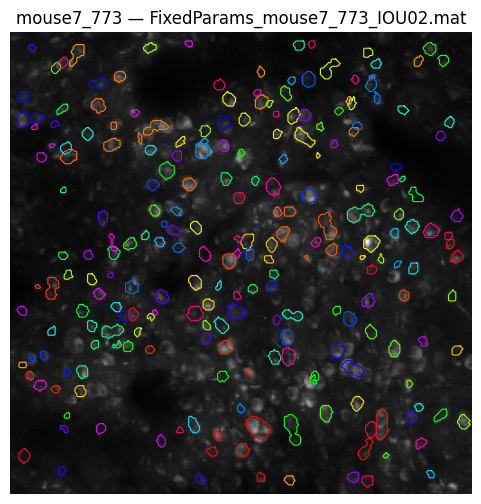

In [8]:
# Visualize SUNS predicted masks over max-projection
import os, h5py, numpy as np, matplotlib.pyplot as plt
from scipy.io import loadmat
from skimage.measure import find_contours

try:
    from suns import config
except Exception:
    import importlib; config = importlib.import_module('suns.config')

# Set which video to visualize
Exp_ID = config.EXP_ID_SETS[config.ACTIVE_EXP_SET][0]  # e.g. 'mouse7_773'
dir_video = config.DATAFOLDER_SETS[config.ACTIVE_EXP_SET]
# Where postproc-only saved your results (from your notebook)
output_base = os.path.join(config.DATAFOLDER_SETS['mouse7_new'], 'output_IOU_02')
dir_output = os.path.join(output_base, 'output_masks')

# Pick the saved mask file (try Output_Masks first, else FixedParams_...IOU02)
cand = [
    os.path.join(dir_output, f'Output_Masks_{Exp_ID}.mat'),
    os.path.join(dir_output, f'FixedParams_{Exp_ID}_IOU02.mat'),
]
pred_path = next((p for p in cand if os.path.exists(p)), None)
assert pred_path is not None, f'No predictions for {Exp_ID} in {dir_output}'

# Load video and get max projection and spatial dims
h5_path = os.path.join(dir_video, f'{Exp_ID}.h5')
with h5py.File(h5_path, 'r') as f:
    # find a 3D dataset
    dset = next(k for k,v in f.items() if hasattr(v, 'shape') and len(v.shape) == 3)
    arr = f[dset][:]
T, Lx, Ly = arr.shape
maxproj = arr.max(axis=0)

# Load masks (dense if present; else convert sparse Masks_2 → dense)
md = loadmat(pred_path, squeeze_me=True)
if 'Masks' in md:
    # Expect (n, Lx, Ly) or (Lx, Ly, n); normalize to (n, Lx, Ly)
    M = md['Masks']
    if M.ndim == 3 and M.shape[0] in (Lx, Ly):
        # Likely (Lx, Ly, n)
        M = np.transpose(M, (2, 0, 1))
    masks_n_lx_ly = M.astype(bool)
else:
    # Masks_2 is (n, Lx*Ly) sparse; convert to dense and reshape
    M2 = md['Masks_2']
    try:
        M2 = M2.tocsr()
        dense = M2.toarray()
    except Exception:
        # Fallback for MATLAB sparse struct
        data = np.ravel(M2['data']).astype(np.float32)
        ir = np.ravel(M2['ir']).astype(np.int32)
        jc = np.ravel(M2['jc']).astype(np.int32)
        shape = tuple(int(x) for x in np.ravel(M2['shape']))
        from scipy.sparse import csc_matrix
        dense = csc_matrix((data, ir, jc), shape=shape).tocsr().toarray()
    n = dense.shape[0]
    masks_n_lx_ly = dense.reshape(n, Lx, Ly).astype(bool)

# Plot overlay of mask contours
plt.figure(figsize=(6,6))
plt.imshow(maxproj, cmap='gray', origin='lower')
n_show = min(200, masks_n_lx_ly.shape[0])
rng = np.random.default_rng(0)
colors = plt.cm.hsv(np.linspace(0, 1, n_show, endpoint=False))
idxs = np.arange(n_show)
for i, ci in zip(idxs, colors):
    m = masks_n_lx_ly[i]
    if not m.any(): 
        continue
    for c in find_contours(m.astype(float), 0.5):
        plt.plot(c[:,1], c[:,0], color=ci, lw=0.8)
plt.title(f'{Exp_ID} — {os.path.basename(pred_path)}')
plt.axis('off')
plt.show()

In [9]:
import os, h5py
from scipy.io import loadmat

Exp_ID = 'mouse7_773'  # change as needed
dir_output = '/gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new/output_IOU_02/output_masks'
pred_path = os.path.join(dir_output, f'FixedParams_{Exp_ID}_IOU02.mat')  # or Output_Masks_{Exp_ID}.mat

md = loadmat(pred_path, squeeze_me=True)
if 'times_cons' in md:
    n_masks = len(md['times_cons'])
elif 'Masks_2' in md:
    M2 = md['Masks_2']
    try:
        n_masks = int(min(M2.shape))
    except Exception:
        n_masks = int(min(md['Masks_2']['shape'].ravel()))
elif 'Masks' in md:
    M = md['Masks']
    n_masks = M.shape[0] if M.ndim == 3 and M.shape[0] != M.shape[1] else M.shape[-1]
else:
    raise KeyError('No Masks/times_cons in file')

print('num masks:', n_masks)

num masks: 580


In [10]:
# Visualize SUNS predicted masks over max-projection

import os, h5py, numpy as np, matplotlib.pyplot as plt
from scipy.io import loadmat
from skimage.measure import find_contours

from suns import config

# Choose which video to visualize
Exp_ID = config.EXP_ID_SETS[config.ACTIVE_EXP_SET][0]  # e.g., 'mouse7_773'
dir_video = config.DATAFOLDER_SETS[config.ACTIVE_EXP_SET]

# Where this notebook saved postproc results
output_base = os.path.join(config.DATAFOLDER_SETS['mouse7_new'], 'output_IOU_02')
dir_output = os.path.join(output_base, 'output_masks')

# Prefer Output_Masks_*.mat if present, else FixedParams_*_IOU02.mat
cand = [
    os.path.join(dir_output, f'Output_Masks_{Exp_ID}.mat'),
    os.path.join(dir_output, f'FixedParams_{Exp_ID}_IOU02.mat'),
]
pred_path = next((p for p in cand if os.path.exists(p)), None)
assert pred_path is not None, f'No predictions for {Exp_ID} in {dir_output}'

# Load the raw video to compute a max-projection
h5_path = os.path.join(dir_video, f'{Exp_ID}.h5')
with h5py.File(h5_path, 'r') as f:
    # find a 3D dataset
    dset = next(k for k,v in f.items() if hasattr(v, 'shape') and len(v.shape) == 3)
    arr = f[dset][:]
T, Lx, Ly = arr.shape
maxproj = arr.max(axis=0)

# Load masks (dense if 'Masks', else convert sparse 'Masks_2' to dense)
md = loadmat(pred_path, squeeze_me=True)
if 'Masks' in md:
    M = md['Masks']
    if M.ndim == 3 and M.shape[0] in (Lx, Ly):  # likely (Lx, Ly, n)
        M = np.transpose(M, (2, 0, 1))
    masks_n_lx_ly = M.astype(bool)
else:
    M2 = md['Masks_2']
    try:
        M2 = M2.tocsr()
        dense = M2.toarray()
    except Exception:
        data = np.ravel(M2['data']).astype(np.float32)
        ir = np.ravel(M2['ir']).astype(np.int32)
        jc = np.ravel(M2['jc']).astype(np.int32)
        shape = tuple(int(x) for x in np.ravel(M2['shape']))
        from scipy.sparse import csc_matrix
        dense = csc_matrix((data, ir, jc), shape=shape).tocsr().toarray()
    n = dense.shape[0]
    masks_n_lx_ly = dense.reshape(n, Lx, Ly).astype(bool)

# Plot overlay of mask contours
plt.figure(figsize=(6,6))
plt.imshow(maxproj, cmap='gray', origin='lower')
n_show = min(200, masks_n_lx_ly.shape[0])
colors = plt.cm.hsv(np.linspace(0, 1, n_show, endpoint=False))
for i, ci in zip(range(n_show), colors):
    m = masks_n_lx_ly[i]
    if not m.any():
        continue
    for c in find_contours(m.astype(float), 0.5):
        plt.plot(c[:,1], c[:,0], color=ci, lw=0.8)
plt.title(f'{Exp_ID} — {os.path.basename(pred_path)}')
plt.axis('off')
plt.show()

AssertionError: No predictions for mouse7_773 in /gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new/output_IOU_02/output_masks